### Experiments with training spectral bias

Imports

In [44]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os
from datetime import datetime
import argparse
import torch.nn.functional as F

Set save to True if you want to save plots

In [45]:
save = True

Only for python script: uncomment if running on cluster

In [46]:
# These are both placeholders
num_epochs = 1000
model_name = 'f0'

In [47]:
# # Parse command-line arguments
# parser = argparse.ArgumentParser(description='Train a neural network model')
# parser.add_argument('--epochs', type=int, default=1000, help='Number of training epochs')
# parser.add_argument('--model_name', type=str, default='model', help='Name of the saved model')
# args = parser.parse_args()

# # Use the parsed arguments
# num_epochs = args.epochs
# model_name = args.model_name

Check if CUDA is available

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [49]:
# For reproducibility
seed = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

**Simplified function generation**

In [50]:
def generate_freq_dataset(num_samples, num_points, min_freq, max_freq):
    x = torch.linspace(0, 2 * np.pi, num_points, requires_grad=True)
    functions = []
    derivatives = []
    
    for _ in range(num_samples):
        num_freqs = torch.randint(min_freq, max_freq * 2, (1,)).item()
        amplitudes = torch.rand(num_freqs * 2)  # Double the number of amplitudes
        sin_frequencies = torch.randint(min_freq, max_freq + 1, (num_freqs,)).float()
        cos_frequencies = torch.randint(min_freq, max_freq + 1, (num_freqs,)).float()
        phases = torch.rand(num_freqs * 2) * 2 * np.pi  # Double the number of phases
        
        y = sum(a * torch.sin(f * x + p) for a, f, p in zip(amplitudes[:num_freqs], sin_frequencies, phases[:num_freqs])) + \
            sum(a * torch.cos(f * x + p) for a, f, p in zip(amplitudes[num_freqs:], cos_frequencies, phases[num_freqs:]))
        
        dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
        
        functions.append(y.detach().numpy())
        derivatives.append(dy_dx.detach().numpy())
    
    return np.array(functions), np.array(derivatives)

## Generate datasets

In [51]:
num_samples = 500
num_points = 1000
batch_size = 32

low_freq_functions, low_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 5)
general_freq_functions, general_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 15)
high_freq_functions, high_freq_derivatives = generate_freq_dataset(num_samples, num_points, 10, 15)

low_freq_dataset = TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives))
general_freq_dataset = TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives))
high_freq_dataset = TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives))

low_freq_dataloader = DataLoader(TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives)), batch_size=batch_size, shuffle=True)
high_freq_dataloader = DataLoader(TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives)), batch_size=batch_size, shuffle=True)
general_freq_dataloader = DataLoader(TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives)), batch_size=batch_size, shuffle=True)

In [52]:
total_size = len(low_freq_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)

# low freq
train_dataset_l, test_dataset_l = random_split(low_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_l = DataLoader(train_dataset_l, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_l = DataLoader(test_dataset_l, batch_size=32, shuffle=False, drop_last=True)

# general freq
train_dataset_g, test_dataset_g = random_split(general_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_g = DataLoader(train_dataset_g, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_g = DataLoader(test_dataset_g, batch_size=32, shuffle=False, drop_last=True)

# high freq
train_dataset_h, test_dataset_h = random_split(high_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_h = DataLoader(train_dataset_h, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_h = DataLoader(test_dataset_h, batch_size=32, shuffle=False, drop_last=True)


## Plot random function from one of the datasets

In [53]:
plt.rcParams.update({
    'axes.titlesize': 20,     # Font size for titles
    'axes.labelsize': 20,     # Font size for x and y labels
})

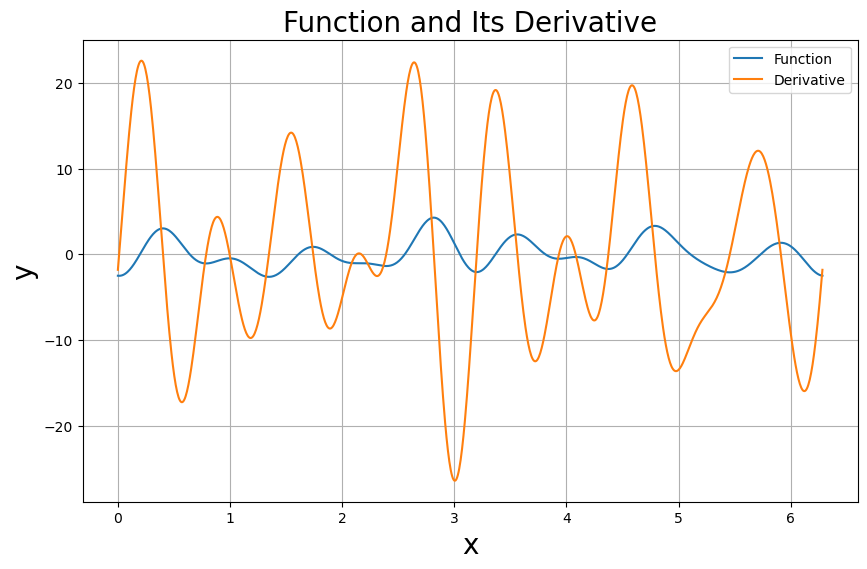

In [54]:
a = np.random.randint(32)
a = 10

fun, deriv = next(iter(general_freq_dataloader))

first_function = fun[a]
first_derivative = deriv[a]

# Generate x values corresponding to the function inputs
x_values = np.linspace(0, 2 * np.pi, 1000)

# Plotting the function and its derivative
plt.figure(figsize=(10, 6))
plt.plot(x_values, first_function, label='Function')
plt.plot(x_values, first_derivative, label='Derivative')
plt.title('Function and Its Derivative')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

## Miscellaneous plotting functions

In [55]:
def plot_losses(train_losses, test_losses, save_dir='plots', filename=None, save=False):
    if not train_losses:
        return
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    current_date = datetime.now().strftime("%m-%d")
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"
    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)    
    plt.show()

In [56]:
def plot_output(epoch, model1, dataset, order=None, save_dir='plots', filename=None, save=False): 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    current_date = datetime.now().strftime("%m-%d")
    model1.eval()  # Set the model to evaluation mode

    train_dataloader_viz = get_random_function(dataset, shuffle=False)
    # Get a random sample from the dataloader
    dataiter = iter(train_dataloader_viz)
    function, true_derivative = next(dataiter)

    # Reshape the input for the model
    function = function.unsqueeze(1)  # Add channel dimension

    # Make prediction
    with torch.no_grad():
        if order == 1 or order == 2:
            predicted_derivative = model1(function)
        
        if order == 'rollout':
            predicted_derivative = model1(function)
            predicted_derivative = model1(predicted_derivative)

    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()
    function = function.squeeze().numpy()

    predicted_derivative = predicted_derivative.squeeze().numpy()

    true_derivative = true_derivative.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(12, 6))

    # plt.plot(x, function, label='Original Function', color='blue')
    if order == 1:
        plt.plot(x, true_derivative, label=f'True {order}st derivative')

    plt.plot(x[10:-10], predicted_derivative[10:-10], label=f'Predicted {order}nd Derivative', linestyle='--')

    plt.title(f'True and Predicted Derivatives at Epoch {epoch}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"

    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

In [57]:
def get_random_function(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=1, shuffle=shuffle)

## Function to train model

In [58]:
criterion = nn.MSELoss()

In [59]:
# train_losses, test_losses = [], []

# def model_training(model, train_dataloader, test_dataloader, num_epochs,\
#     split_freq=None, filename=None, save=None, order=None):
#     train_losses = []
#     test_losses = []

#     low_freq_nmses = []
#     general_freq_nmses = []
#     high_freq_nmses = []
#     epoch_list = []

#     lr = 1e-3

#     optimizer = optim.Adam(model.parameters(), lr=lr)

#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0.0
#         test_loss = 0.0

#         if epoch % split_freq == 0:
#             l, g, h = print_and_store_metrics(model)
#             low_freq_nmses.append(l)
#             general_freq_nmses.append(g)
#             high_freq_nmses.append(h)
#             epoch_list.append(epoch)

#         for batch_functions, batch_derivatives in train_dataloader:
#             batch_functions = batch_functions.unsqueeze(1)
#             batch_derivatives = batch_derivatives.unsqueeze(1)

#             outputs = model(batch_functions)
#             loss = criterion(outputs, batch_derivatives)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
#         train_loss /= len(train_dataloader)

#         model.eval()
#         with torch.no_grad():
#             for b_test_functions, b_test_derivatives in test_dataloader:
#                 b_test_functions = b_test_functions.unsqueeze(1)
#                 b_test_derivatives = b_test_derivatives.unsqueeze(1)

#                 test_outputs = model(b_test_functions)
#                 batch_test_loss = criterion(test_outputs, b_test_derivatives)

#                 test_loss += batch_test_loss.item()

#         test_loss /= len(test_dataloader)

#         train_losses.append(train_loss)
#         test_losses.append(test_loss)

#         print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

#     print(f"Training finished for {order}st derivative")

#     plt.figure(figsize=(10, 6))
#     plt.plot(epoch_list, low_freq_nmses, label='Low freq NMSE')
#     plt.plot(epoch_list, general_freq_nmses, label='General freq NMSE')
#     plt.plot(epoch_list, high_freq_nmses, label='High freq NMSE')

#     # Adding labels and title
#     plt.xlabel('Epoch')
#     plt.ylabel('NMSE')
#     plt.yscale('log')
#     plt.title('NMSEs of different frequencies during training')
#     plt.legend()

#     # Show the plot
#     plt.grid(True)
#     plt.show()
#     if save:
#         plt.savefig(filename)  

#     return train_losses, test_losses

## Metric functions

In [60]:
def compute_mse(dataloader, model):
    """
    Takes in a dataloader and a model to compute MSE.
    """

    model.eval()
    all_outputs = []
    all_targets = []

    for function, deriv in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)

        # Compute model output
        model_output = model(function)
        all_targets.append(deriv)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_targets - all_outputs) ** 2)
    nmse = mse / torch.mean(all_targets ** 2)

    return mse.item(), nmse.item()

criterion = torch.nn.MSELoss()

In [61]:
def print_and_store_metrics(f0):
    return compute_mse(test_dataloader_l, f0)[1], compute_mse(test_dataloader_g, f0)[1], compute_mse(test_dataloader_h, f0)[1]

In [62]:
def print_metrics(model):
    print(f"MSE over low freq test functions: {compute_mse(test_dataloader_l, model)[0]}")
    print(f"MSE over general freq test functions: {compute_mse(test_dataloader_g, model)[0]}")
    print(f"MSE over high freq test functions: {compute_mse(test_dataloader_h, model)[0]}\n")

    print(f"NMSE over low freq test functions: {compute_mse(test_dataloader_l, model)[1]}")
    print(f"NMSE over general freq test functions: {compute_mse(test_dataloader_g, model)[1]}")
    print(f"NMSE over high freq test functions: {compute_mse(test_dataloader_h, model)[1]}")



## Create models

In [63]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self, n_layers=3, kernel_size=3, hidden_size=64):
        super(SimpleCNN, self).__init__()
        # Parameters
        self.n_layers = n_layers
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size

        # Model
        self.convs = nn.ModuleList()
        if n_layers == 1:
            self.convs.append(nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size//2))
        elif n_layers >= 2:
            self.convs.append(nn.Conv1d(1, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            for _ in range(n_layers - 2):
                self.convs.append(nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            self.convs.append(nn.Conv1d(hidden_size, 1, kernel_size=kernel_size, padding=kernel_size//2))
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        for i, conv in enumerate(self.convs):
            if i < len(self.convs) - 1:
                x = self.relu(conv(x))
            else:
                x = conv(x)
        return x

In [64]:
set_seed(seed)
L3ModelK3 = SimpleCNN(n_layers=3, kernel_size=3)

In [65]:
# train_losses, test_losses = model_training(L3ModelK3, train_dataloader_g, test_dataloader_g,\
#     num_epochs=1000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
#     save=save, order='first')
# plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

## Plot results

In [66]:
def plot_all_outputs(model, model_name, epoch=None):
    # plot_output(model, dataset=test_dataset_l, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    plot_output(epoch, model, dataset=test_dataset_g, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    # plot_output(model, dataset=test_dataset_h, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)

In [67]:
train_losses, test_losses = [], []

def model_training(model, num_epochs, lr_factor=1, train_dataloader=train_dataloader_g, order=None):
    train_losses = []
    test_losses = []

    lr = 1e-3 / lr_factor

    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch_functions, batch_derivatives in train_dataloader:
            # Reshape input: [batch_size, 1, num_points]
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            # Forward pass
            outputs = model(batch_functions)
            loss = criterion(outputs, batch_derivatives)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        # model.eval()
        # with torch.no_grad():
        #     for b_test_functions, b_test_derivatives, _ in test_dataloader:
        #         b_test_functions = b_test_functions.unsqueeze(1)
        #         b_test_derivatives = b_test_derivatives.unsqueeze(1)

        #         test_outputs = model(b_test_functions)
        #         batch_test_loss = criterion(test_outputs, b_test_derivatives)

        #         test_loss += batch_test_loss.item()

        # test_loss /= len(test_dataloader)

        # train_losses.append(train_loss)
        # test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    print(f"Training finished for {order}st derivative")
    return train_losses, test_losses

In [91]:
set_seed(seed)
L3ModelK3 = SimpleCNN(n_layers=3, kernel_size=3)
train_iters = 100
train_losses, test_losses = model_training(L3ModelK3, train_iters, order='first')


Epoch [1/100], Train Loss: 422.7264, Test Loss: 0.0000
Epoch [2/100], Train Loss: 409.9263, Test Loss: 0.0000
Epoch [3/100], Train Loss: 381.9070, Test Loss: 0.0000
Epoch [4/100], Train Loss: 343.2166, Test Loss: 0.0000
Epoch [5/100], Train Loss: 274.1533, Test Loss: 0.0000
Epoch [6/100], Train Loss: 191.4754, Test Loss: 0.0000
Epoch [7/100], Train Loss: 104.6640, Test Loss: 0.0000
Epoch [8/100], Train Loss: 43.5910, Test Loss: 0.0000
Epoch [9/100], Train Loss: 17.6242, Test Loss: 0.0000
Epoch [10/100], Train Loss: 14.6822, Test Loss: 0.0000
Epoch [11/100], Train Loss: 13.9826, Test Loss: 0.0000
Epoch [12/100], Train Loss: 13.0074, Test Loss: 0.0000
Epoch [13/100], Train Loss: 12.6764, Test Loss: 0.0000
Epoch [14/100], Train Loss: 11.9573, Test Loss: 0.0000
Epoch [15/100], Train Loss: 11.2816, Test Loss: 0.0000
Epoch [16/100], Train Loss: 11.1580, Test Loss: 0.0000
Epoch [17/100], Train Loss: 10.9278, Test Loss: 0.0000
Epoch [18/100], Train Loss: 10.5156, Test Loss: 0.0000
Epoch [19/10

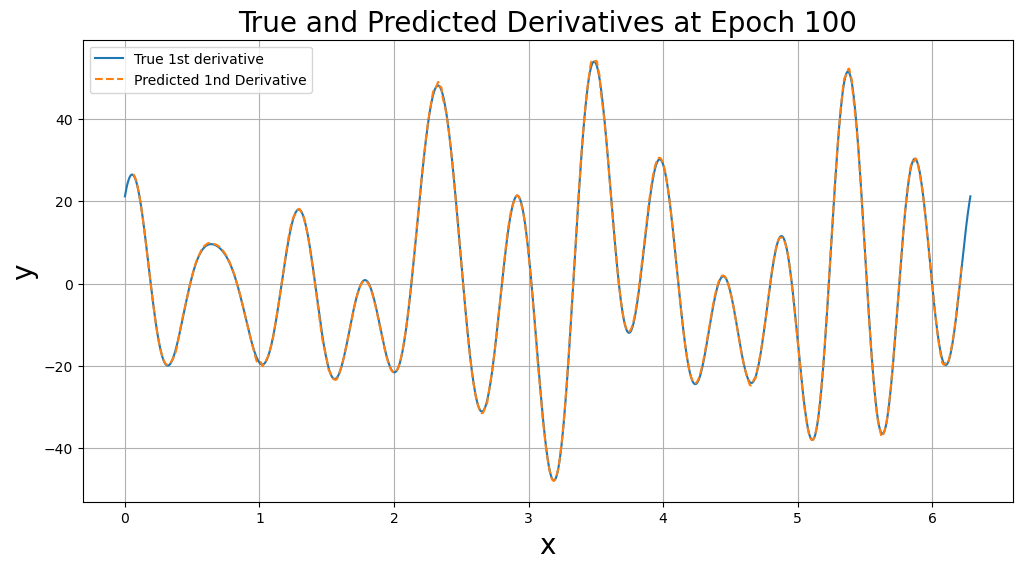

In [92]:
plot_all_outputs(L3ModelK3, model_name = 'L3ModelK3', epoch=train_iters)

In [70]:
print_metrics(L3ModelK3)

MSE over low freq test functions: 17.96661949157715
MSE over general freq test functions: 448.9374084472656
MSE over high freq test functions: 1074.9583740234375

NMSE over low freq test functions: 0.9995055198669434
NMSE over general freq test functions: 0.9994832873344421
NMSE over high freq test functions: 0.9995225071907043


In [71]:
set_seed(seed)
L3ModelK3 = SimpleCNN(n_layers=3, kernel_size=3)

In [72]:
L3ModelK3.load_state_dict(torch.load('../../models/3_layers.pth'))

<All keys matched successfully>

In [73]:
# train_losses, test_losses = model_training(L3ModelK9, train_dataloader_g, test_dataloader_g,\
#     num_epochs=1000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
#     save=save, order='first')
# plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

In [74]:
print_metrics(L3ModelK3)

MSE over low freq test functions: 0.04102856665849686
MSE over general freq test functions: 0.08162455260753632
MSE over high freq test functions: 0.27204886078834534

NMSE over low freq test functions: 0.002282470464706421
NMSE over general freq test functions: 0.00018172328418586403
NMSE over high freq test functions: 0.00025295765954069793


## Finite-difference methods

**First-order**

In [75]:
def first_order_FD(function, dx):

    n = len(function)
    derivative = np.zeros(n)

    # Forward for all except last value
    for i in range(n - 1):
        d_fun = (function[i+1] - function[i]) / dx
        derivative[i] = d_fun

    # Backward for the last value
    d_fun = (function[n-1] - function[n-2]) / dx
    derivative[n-1] = d_fun

    return derivative
    


In [76]:
i = np.random.randint(32)
first_function, first_derivative = train_dataset_l[i]

In [77]:
first_order_approx = first_order_FD(first_function, np.pi*2/1000)

In [78]:
def print_mse(true, predicted):
    mse = torch.mean((true - predicted) ** 2)
    nmse = mse / torch.mean(true ** 2)
    print(f"MSE: {mse}")
    print(f"NMSE: {nmse}")

In [79]:
print_mse(first_derivative, first_order_approx)

MSE: 0.0009062396725411359
NMSE: 0.0001474944050375354


**Second order**

In [80]:
def second_order_FD(function, dx):

    n = len(function)
    derivative = np.zeros(n)

    # Forward for all except last value
    for i in range(n - 2):
        d_fun = (-3*function[i] + 4*function[i+1] - function[i+2]) / (2*dx)
        derivative[i] = d_fun

    # Backward for the last value
    for i in range(n-2, n):
        d_fun = (3*function[i] - 4*function[i-1] + function[i-2]) / (2*dx)
        derivative[i] = d_fun

    return derivative
    


In [81]:
second_order_approx = second_order_FD(first_function, np.pi*2/1000)
print_mse(first_derivative, second_order_approx)

MSE: 8.8084942228751e-06
NMSE: 1.433620325886315e-06


**Third-order finite difference**

In [82]:
def third_order_FD(function, dx):
    n = len(function)
    derivative = np.zeros(n)

    for i in range(n-3):
        derivative[i] = (-11*function[i] + 18*function[i+1] - 9*function[i+2] + 2*function[i+3]) / (6*dx)    
    
    for i in range(n-3, n):
        derivative[i] = (11*function[i] - 18*function[i-1] + 9*function[i-2] - 2*function[i-3]) / (6*dx)    
    
    return derivative

In [83]:
third_order_approx = third_order_FD(first_function, np.pi*2/1000)
print_mse(first_derivative, third_order_approx)

MSE: 6.166730181160887e-06
NMSE: 1.003661864136776e-06


**Fourth-order finite difference**

In [84]:
def fourth_order_FD(function, dx):
    n = len(function)
    derivative = np.zeros(n)

    for i in range(n-4):
        derivative[i] = (-25*function[i] + 48*function[i+1] - 36*function[i+2] + 16*function[i+3] - 3*function[i+4]) / (12*dx)    
    
    for i in range(n-4, n):
        derivative[i] = (25*function[i] - 48*function[i-1] + 36*function[i-2] - 16*function[i-3] + 3*function[i-4]) / (12*dx)    
    
    return derivative

In [85]:
fourth_order_approx = fourth_order_FD(first_function, np.pi*2/1000)
print_mse(first_derivative, fourth_order_approx)


MSE: 6.170445947784372e-06
NMSE: 1.0042666211386987e-06


Not sure why I can't get to higher precision...